In [1]:
%run preprocess.ipynb
%run preprocessing_tweets.ipynb
import os 
import numpy as np
import json
import gensim
import nltk
import re
from nltk.corpus import stopwords
from copy import deepcopy
import pickle
from nltk.tokenize import TweetTokenizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# from preprocess import read_data
# from preprocess import get_features
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
all_data = read_data()

580323060533764097


In [33]:
def with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test,count,title):
    cv = CountVectorizer()
    cv_fit=cv.fit_transform(BOW_sents)
    BOW_features = cv_fit.toarray()
    
    # Append features with Bag of words
    X = []
    for i in range(len(BOW_features)):
        line = list(BOW_features[i]) + all_extra_feats[i]
        X.append(line)
        
    model.fit(X, Y)

    # preprocess testing set
    test_cv_fit = cv.transform(test_BOW_sents)
    test_BOW_features = test_cv_fit.toarray()

    # Append features
    X_test = []
    for i in range(len(test_BOW_features)):
        line = list(test_BOW_features[i]) + test_all_extra_feats[i]
        X_test.append(line)
        
    Y_pred = model.predict(X_test)
    if count==1:
#         print("Confidence: ",class_probabilities = model.predict_proba(sub_main))
        print("Confidence: ",model.predict_proba(X_test))
    print("accuracy : ", accuracy_score(Y_test, Y_pred))
    print("Macro F: ", f1_score(Y_test, Y_pred, average='macro'))
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in range(3)],columns = [i for i in range(3)])
    plt.figure(figsize = (6,4))
#     sn.heatmap(df_cm, annot=True)
    svm = sn.heatmap(df_cm, annot=True)
    fig = svm.get_figure()
    fig.savefig(title)
    return Y_pred

In [34]:
def without_tweet_context(X, Y, model, X_test, Y_test,count,title):
    model.fit(X, Y)
    Y_pred = model.predict(X_test)
    if count==1:
        print("Confidence: ",model.predict_proba(X_test))
    print("accuracy : ", accuracy_score(Y_test, Y_pred))
    print("Macro F: ", f1_score(Y_test, Y_pred, average='macro'))
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in range(3)],columns = [i for i in range(3)])
    plt.figure(figsize = (6,4))
#     sn.heatmap(df_cm, annot=True)   
    svm = sn.heatmap(df_cm, annot=True)
    fig = svm.get_figure()
    fig.savefig(title)
    return Y_pred

In [35]:
def write_to_json(ids, pred, path):
    submission = {}
    for i, id in enumerate(ids):
        submission[id] = [pred[i], 1]
        subtaskaenglish = {}
        subtaskbenglish = {}
        
    answer = {}
    answer['subtaskaenglish'] = {}
    answer['subtaskbenglish'] = submission

    answer['subtaskadanish'] = {}
    answer['subtaskbdanish'] = {}

    answer['subtaskarussian'] = {}
    answer['subtaskbrussian'] = {}
        
    with open(path, 'w') as f:
        json.dump(answer, f)

In [36]:
from sklearn.calibration import CalibratedClassifierCV

<class 'sklearn.calibration.CalibratedClassifierCV'>
Without the context of the tweet in context
Confidence:  [[0.2152779  0.46318373 0.32153837]
 [0.33052552 0.37650581 0.29296867]
 [0.26302885 0.4193373  0.31763385]
 [0.34899503 0.36414612 0.28685885]
 [0.3367973  0.36072541 0.30247729]
 [0.27519478 0.4117104  0.31309482]
 [0.18258962 0.48557805 0.33183234]
 [0.26943328 0.4162126  0.31435412]
 [0.28991974 0.40027428 0.30980597]
 [0.43681079 0.28326338 0.27992583]
 [0.41711641 0.30096593 0.28191766]
 [0.24584552 0.42797664 0.32617784]
 [0.26490934 0.41666461 0.31842605]
 [0.30182075 0.39109637 0.30708288]
 [0.28802204 0.40174286 0.3102351 ]
 [0.3361735  0.36415342 0.29967308]
 [0.31139043 0.3836795  0.30493007]
 [0.28014267 0.41346404 0.30639329]
 [0.32584823 0.37050477 0.303647  ]
 [0.23156626 0.44628906 0.32214468]
 [0.41598932 0.31176909 0.27224159]
 [0.29732784 0.39320994 0.30946222]
 [0.29834294 0.39377296 0.3078841 ]
 [0.14100618 0.52521321 0.33378061]
 [0.13016516 0.53490142 0.

/home/dhawal/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dhawal/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



With the context of the tweet in context


/home/dhawal/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confidence:  [[0.25181109 0.50015236 0.24803655]
 [0.27005993 0.4229025  0.30703757]
 [0.308535   0.50619132 0.18527369]
 [0.31335259 0.42894427 0.25770314]
 [0.30381972 0.43246967 0.2637106 ]
 [0.23121016 0.56210859 0.20668125]
 [0.19654067 0.61811819 0.18534114]
 [0.20216263 0.59620699 0.20163038]
 [0.31747643 0.41337412 0.26914945]
 [0.33993297 0.44615432 0.21391271]
 [0.33194016 0.45537383 0.21268601]
 [0.30450412 0.48313675 0.21235913]
 [0.33807716 0.46154138 0.20038146]
 [0.31050352 0.47546195 0.21403453]
 [0.30867622 0.44937165 0.24195213]
 [0.31665396 0.46869931 0.21464672]
 [0.30292242 0.44773599 0.24934159]
 [0.34698509 0.46720621 0.1858087 ]
 [0.33712484 0.49353434 0.16934082]
 [0.31933735 0.51492807 0.16573458]
 [0.26897228 0.39569333 0.33533438]
 [0.28421366 0.46866532 0.24712102]
 [0.33866196 0.49221621 0.16912183]
 [0.24998241 0.48191732 0.26810027]
 [0.24611053 0.47848991 0.27539956]
 [0.32835303 0.42471671 0.24693027]
 [0.30050643 0.43240576 0.26708781]
 [0.27457596 0.

/home/dhawal/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy :  0.5308641975308642
Macro F:  0.4863199772662688

With the context of the tweet in context
accuracy :  0.49382716049382713
Macro F:  0.42492148899471566
--------


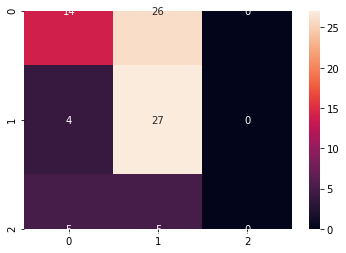

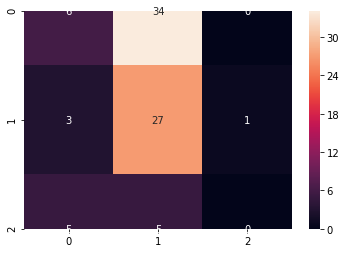

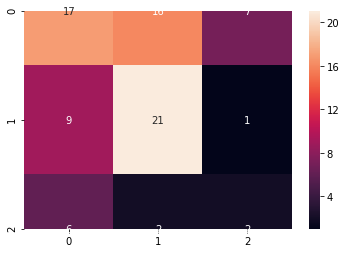

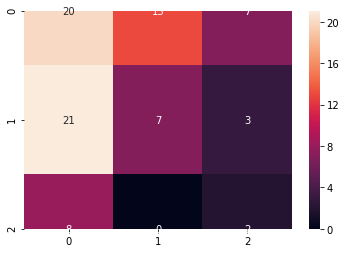

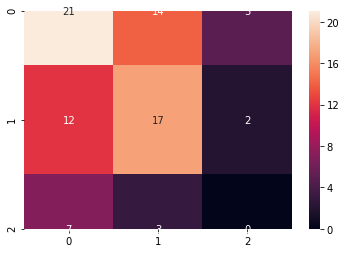

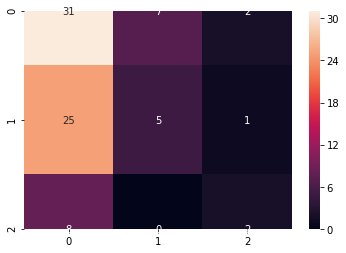

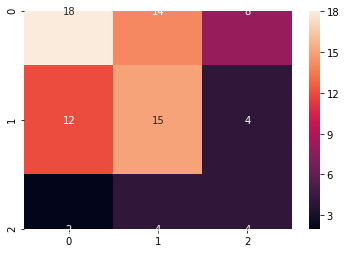

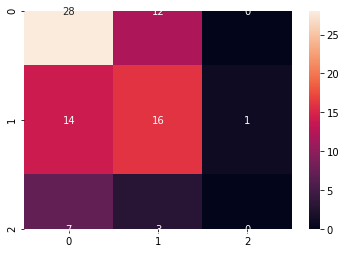

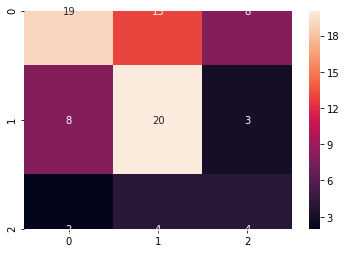

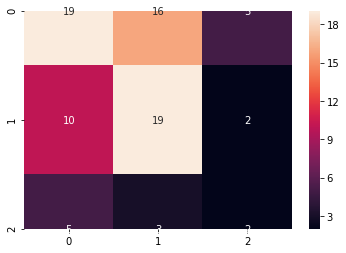

In [37]:
# def main(all_data):
    # Get Bag Of Words
BOW_sents, all_extra_feats, Y, ids = get_features(all_data, whichset="training+development")

test_BOW_sents, test_all_extra_feats, Y_test, ids_test = get_features(all_data, whichset="testing")

with open('rumoureval2019_data/final-eval-key.json') as fil:
    test = json.load(fil)
for ids in ids_test:
    Y_test.append(test['subtaskbenglish'][ids])

models = []
models.append(CalibratedClassifierCV(LinearSVC(random_state=364)))
models.append(MLPClassifier(hidden_layer_sizes=(100,50),max_iter=1000))
models.append(LogisticRegression(multi_class='multinomial',solver='lbfgs'))
models.append(tree.DecisionTreeClassifier())
models.append(RandomForestClassifier())


count = 1
for model in models:
    print(type(model))
    print("Without the context of the tweet in context")
    Y_pred = without_tweet_context(all_extra_feats, Y, model, test_all_extra_feats, Y_test,count,"model_without_"+str(count)+".png")
    path = "answer_without_"+str(count)+".json"
    write_to_json(ids_test, Y_pred, path)
    print()
    print("With the context of the tweet in context")
    Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test,count,"model_with_"+str(count)+".png")
    path = "answer_without_"+str(count)+".json"
    write_to_json(ids_test, Y_pred, path)
    print("--------")
    count += 1


In [ ]:
Y_pred = without_tweet_context(all_extra_feats, Y, models[0], test_all_extra_feats, Y_test, 'model0_without')

accuracy :  0.41975308641975306
Macro F:  0.3638858793788371


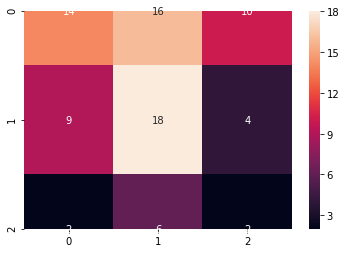

In [7]:
# Y_pred = without_tweet_context(all_extra_feats, Y, model[4], test_all_extra_feats, Y_test)

In [8]:
# !pip install seaborn

accuracy :  0.4567901234567901
Macro F:  0.3404935430251886


/home/dhawal/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy :  0.49382716049382713
Macro F:  0.39783194346188755
accuracy :  0.4691358024691358
Macro F:  0.3493589743589744
accuracy :  0.4444444444444444
Macro F:  0.41111111111111115
accuracy :  0.5308641975308642
Macro F:  0.4515873015873016


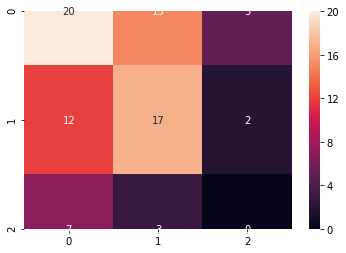

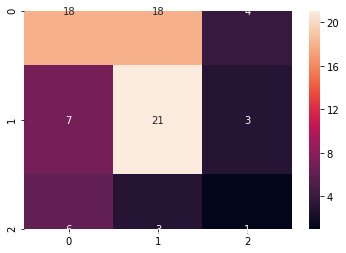

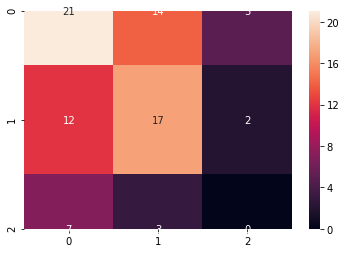

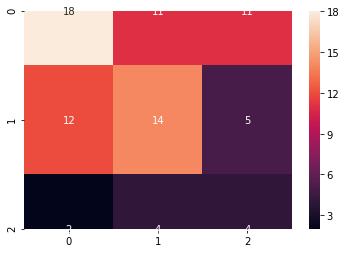

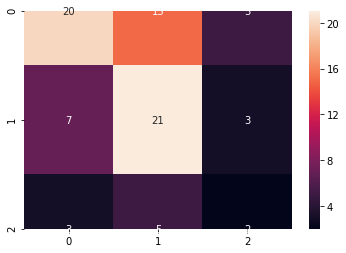

In [9]:
X_axis = []
for model in models:
#     print(type(model))
#     print("Without the context of the tweet in context")
    pred = without_tweet_context(all_extra_feats, Y, model, test_all_extra_feats, Y_test)
    X_axis.append(accuracy_score(Y_test, pred))
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print()
#     print("With the context of the tweet in context")
#     Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print("--------")

#     count += 1

In [10]:
X_axis

[0.4567901234567901,
 0.49382716049382713,
 0.4691358024691358,
 0.4444444444444444,
 0.5308641975308642]

accuracy :  0.41975308641975306
Macro F:  0.3088663300371695
accuracy :  0.3333333333333333
Macro F:  0.2917582417582418
accuracy :  0.4691358024691358
Macro F:  0.36512621745179885
accuracy :  0.5432098765432098
Macro F:  0.38178083846804395
accuracy :  0.5185185185185185
Macro F:  0.36628186628186626


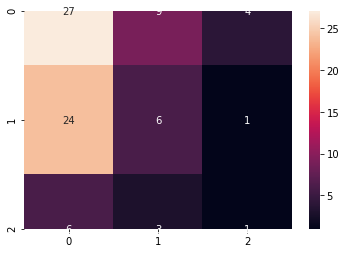

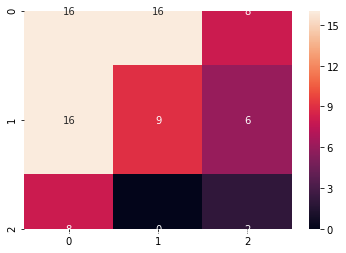

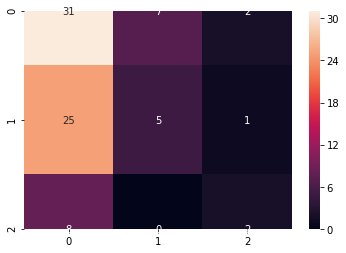

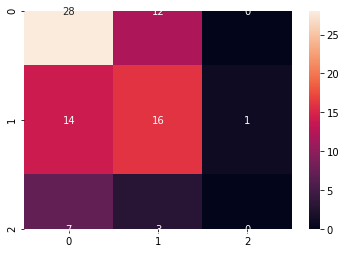

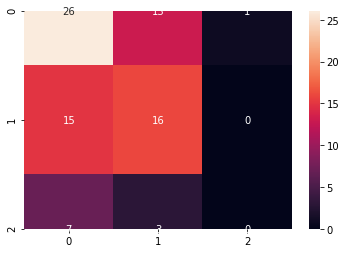

In [11]:
X_axis = []
for model in models:
#     print(type(model))
#     print("Without the context of the tweet in context")
    pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
    X_axis.append(accuracy_score(Y_test, pred))
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print()
#     print("With the context of the tweet in context")
#     Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print("--------")
#     count += 1

without tweet context


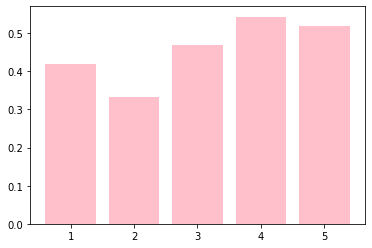

Graph Plotting the variation of accuracy for different models 


In [12]:
print("without tweet context")
plt.bar([1,2,3,4,5], X_axis, color = 'pink')
plt.show()
print("Graph Plotting the variation of accuracy for different models ")